Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL410250 / EEL7513 / EEL7514 - Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\RR}{\mathbb{R}}$


# Exercício 4: Regressão Logística

Neste exercício você irá aplicar um classificador de regressão logística em diversos conjuntos de dados. 
Além disso, você irá explorar a adição de atributos polinomiais e a utilização de regularização, bem como outras formas de avaliação de classificadores binários. Finalmente, você irá investigar técnicas de classificação multi-classe.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gen_data(n_samples=20, n_classes=2, overlap=0, x_scale=[0,1], random_state=None):
    '''Generate 1-D classification dataset'''
    assert overlap <= 1
    rng = np.random.RandomState(random_state)
    X = np.zeros((n_samples,1))
    y = np.zeros(n_samples)
    for i in range(n_samples):
        k = i % n_classes
        X[i,0] = (k*(1-overlap) + rng.rand())/((n_classes-1)*(1-overlap) + 1)
        y[i] = k
    X = x_scale[0] + (x_scale[1]-x_scale[0])*X
    return X, y

def plot_data(X, y, colors=['bo','rx','gs','md','c^','yP']):
    ''' Plot 1-D or 2-D classification dataset '''
    assert len(X.shape) == 2 and len(y.shape) == 1
    classes = np.unique(y)
    assert len(classes) <= len(colors)
    dim = X.shape[1]
    assert 0 < dim <= 2
    if dim == 1:
        for i in range(len(classes)):
            plt.plot(X[y==classes[i],0], np.zeros(np.sum(y==classes[i])), colors[i])
        plt.gca().axes.get_yaxis().set_ticks([])
    else:
        for i in range(len(classes)):
            plt.plot(X[y==classes[i],0], X[y==classes[i],1], colors[i])
    return

def plot_boundary(model, X, colors=['b','r','g','m','c','y'], N=400, gap=1e-9):
    ''' Plot boundary for a 1-D or 2-D classifier '''
    assert len(X.shape) == 2 and len(y.shape) == 1
    dim = X.shape[1]
    assert 0 < dim <= 2
    x1_min, x1_max = X[:,0].min()-gap, X[:,0].max()+gap
    if dim == 1:
        x2_min, x2_max = -1, 1
        N2 = 2
    else:
        x2_min, x2_max = X[:,1].min()-gap, X[:,1].max()+gap
        N2 = N
    xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max,N), np.linspace(x2_min,x2_max,N2))
    if dim == 1:
        X = np.c_[xx1.reshape(-1)]
    else:
        X = np.c_[xx1.reshape(-1), xx2.reshape(-1)]
    y_pred = model.predict(X)
    from sklearn.preprocessing import LabelEncoder
    enc = LabelEncoder()
    y_pred = enc.fit_transform(y_pred)
    assert len(enc.classes_) <= len(colors)
    levels = np.arange(len(enc.classes_)+1)-0.5
    y_pred = y_pred.reshape(xx1.shape)
    plt.contourf(xx1, xx2, y_pred, levels, colors=colors, alpha=0.25)
    plt.contour(xx1, xx2, y_pred, levels, colors='k', linewidths=1)
    return

def plot_errors(model, X, y):
    ''' Draws a square around each incorrect prediction '''
    assert len(X.shape) == 2 and len(y.shape) == 1
    dim = X.shape[1]
    assert 0 < dim <= 2
    err = model.predict(X) != y
    vert = np.zeros(np.sum(err))
    if dim == 2:
        vert = X[err,1]
    plt.plot(X[err,0], vert, 'ks', mfc='none', markersize=10)
    return

In [2]:
# More imports

# 1. Conjunto de dados #1

O primeiro conjunto de dados que usaremos pode ser gerado e visualizado pelos comandos abaixo.

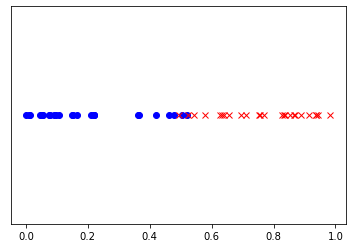

In [3]:
X,y = gen_data(n_samples=50, n_classes=2, overlap=0.1, random_state=1)
plot_data(X, y)

## Classificação linear

1. Treine um classificador de regressão logística sem regularização e trace um gráfico mostrando o conjunto de treinamento e as regiões de decisão do classificador. 
1. Reporte a acurácia (= # de acertos / tamanho do conjunto) do classificador.
1. Determine o valor do limiar de decisão a partir dos parâmetros do modelo.

#### Dicas

- Funções úteis:

```python
sklearn.linear_model.LogisticRegression() # utilize penalty='none'
plot_data(), plot_boundary() # fornecidas, utilize os parâmetros default
LogisticRegression.score(), .coef_, .intercept_
```

-  Caso sua versão do sklearn seja inferior a 0.22, utilize a opção `solver='lbfgs'` (padrão a partir de 0.22) no `LogisticRegression()`

Training accuracy: 96.0%
Decision threshold: 0.511


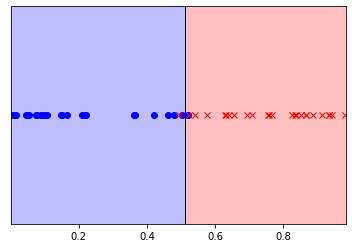

4. Trace o gráfico da predição do modelo de regressão (i.e., da variável contínua $\tilde{y} = \sigma(\bw^T\bx$)) sobre o conjunto de treinamento. Faça isso de três formas diferentes e confirme que todas fornecem o mesmo resultado:
 1. Usando a função `.predict_proba()` do modelo
 1. Escrevendo sua própria implementação a partir da função `.decision_function()`, a qual retorna o score de confiança $z = \bw^T\bx$
 1. Escrevendo sua própria implementação a partir dos parâmetros `.coef_` e `.intercept_`

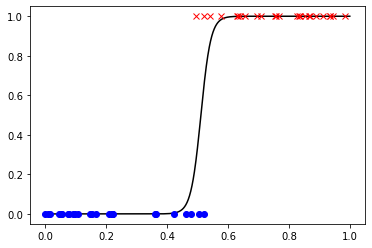

8. Varie o grau de sobreposição no gerador do conjunto de dados (parâmetro `overlap`) e repita o gráfico da predição do item anterior. Para facilitar, copie e cole todos os comandos e os organize em um `for` (ou, se preferir, utilize `ipywidgets.interact`). Utilize o mesmo `seed` do gerador de números aleatórios em todos os casos (parâmetro `random_state` da função `gen_data()`), para eliminar a variabilidade e assim enfatizar a influência do grau de sobreposição.
1. Comente sobre os resultados observados.

# 2. Conjunto de dados #2

O segundo conjunto de dados pode ser gerado pelos comandos abaixo.

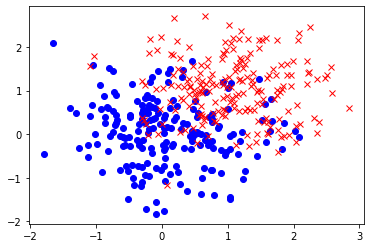

In [6]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=400, n_features=2, centers=[[0,0],[1,1]], cluster_std=0.75, random_state=4)
X_test, y_test = make_blobs(n_samples=400, n_features=2, centers=[[0,0],[1,1]], cluster_std=0.75, random_state=1)
plot_data(X, y)

## Classificação linear

1. Treine um classificador de regressão logística sem regularização e trace um gráfico mostrando o conjunto de treinamento e as regiões de decisão do classificador.
1. Reporte o número de iterações realizadas pelo otimizador, o vetor de parâmetros $\bw$ (incluindo o termo de *bias* $w_0 = b$) e a acurácia do classificador nos conjuntos de treinamento e de teste.


Number of iterations: 11
w = [-2.26363304  1.87889384  2.21613653]
Train accuracy: 85.2%
 Test accuracy: 84.0%


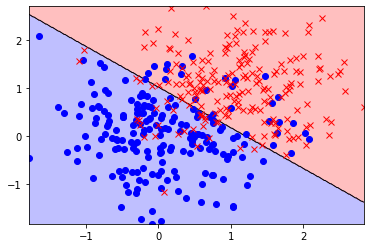

## Matriz de confusão e curva ROC

3. Calcule a matriz de confusão sobre o conjunto de teste.
1. A partir da matriz de confusão, confirme o valor da acurácia de teste e calcule também as taxas de verdadeiro positivo, verdadeiro negativo, falso positivo e falso negativo.
1. (OPCIONAL) Explique por que a acurácia pode ser interpretada como uma média ponderada entre a taxa de verdadeiro positivo e a taxa de verdadeiro negativo.
1. Trace o gráfico da curva ROC sobre o conjunto de teste.
1. Determine a menor taxa de falso positivo tal que a taxa de falso negativo seja de no máximo 5%. Determine também o valor do limiar de decisão correspondente.
1. (OPCIONAL) Modifique o modelo (basta alterar 1 parâmetro) para que, quando avaliado no conjunto de teste, produza exatamente as taxas do item anterior. Em seguida, trace o gráfico das regiões de decisão do novo classificador sobre o conjunto de treinamento e compare-o com o gráfico do item 2.1. Calcule também a acurácia de teste.
1. (OPCIONAL) Compare a abordagem acima com a seguinte abordagem: treine novamente o modelo, variando os pesos do parâmetro `class_weight`, até conseguir a taxa de falso negativo desejada. Quais lhe parecem ser as vantagens e desvantagens dessa abordagem?

#### Dicas
- Funções úteis:
```python
from sklearn.metrics import confusion_matrix, roc_curve
np.where(), np.nonzero()
```

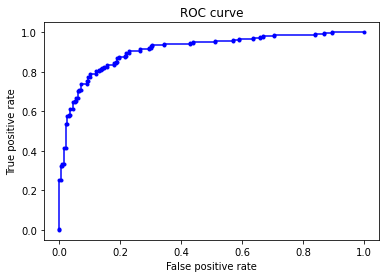

## (OPCIONAL) Implementação em Python

**OBS: É recomendável deixar essa parte para o final, a ser feita caso haja tempo.**

Escreva uma implementação própria do classificador, completando a classe abaixo. Esta implementação é parcialmente compatível com o sklearn; em particular, as classes herdadas permitem automaticamente a utilização da função `.score()`. Para realizar o treinamento utilizaremos o otimizador do SciPy com o método BFGS (padrão do SciPy para problemas sem restrições), um método [quase-Newton](https://en.wikipedia.org/wiki/Quasi-Newton_method) que requer apenas o cálculo do gradiente.

10. Complete as funções `decision_function`, `predict_proba` (que você já implementou acima) e `predict`.
1. Complete a função objetivo da otimização `_fobj`. Esta função deve retornar o valor da função custo e do gradiente no ponto atual ($\bw$).
1. Repita os itens da seção anterior com o seu classificador e compare com a versão do sklearn. Confirme que o valor da acurácia é idêntico e os valores de $\bw$ são muito próximos (até pelo menos o terceiro dígito significativo).

Após essa parte, você pode ignorar a sua implementação e passar a usar a implementação do sklearn.

#### Dicas
- Ao invés de implementar a função logística, utilize a implementação do SciPy (possivelmente renomeando para um nome mais conveniente):
```python
from scipy.special import expit as sigmoid
```
- Adicione um valor pequeno e positivo (ex: `eps = 1e-200`) dentro do argumento do `np.log()` para evitar erros quando o argumento é igual a zero.

In [12]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit as sigmoid

class Model(BaseEstimator, ClassifierMixin):
    ''' Logistic regression with L2 regularization '''
    def __init__(self, lamb=0):
        self.lamb = lamb
        return
    
    def _add_ones(self, X):
        # Add column of ones
        X_new = np.c_[np.ones(X.shape[0]), X]
        return X_new

    def _fobj(self, w, X, y):
        # Compute cost and gradient for optimization
        eps = 1e-200
        ???
        return J, grad
    
    def fit(self, X, y):
        # Fit using BFGS solver (SciPy's default)
        from scipy.optimize import minimize
        X = self._add_ones(X)
        res = minimize(fun=self._fobj, x0=np.zeros(X.shape[1]), jac=True, args=(X,y))
        self.w = res.x
        self.n_iter_ = np.array([res.nit])
        self.J = self._fobj(self.w, X, y)[0]
        return self
    
    def decision_function(self, X):
        X = self._add_ones(X)
        ???
        return z
    
    def predict_proba(self, X):
        ???
        return y_tilde

    def predict(self, X):
        y_pred = (self.decision_function(X) ???).astype(int)
        return y_pred

# 3. Conjunto de dados #3

O próximo conjunto de dados é gerado pelos comandos abaixo. Note que agora temos também conjuntos de validação e de teste (extremamente grandes para fins didáticos).

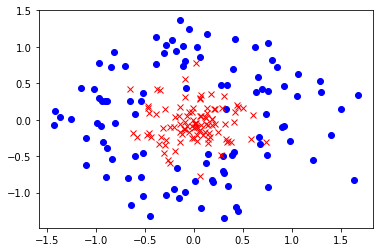

In [15]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=200, noise=0.28, factor=0, random_state=4)
X_val, y_val = make_circles(n_samples=10000, noise=0.28, factor=0, random_state=5)
X_test, y_test = make_circles(n_samples=10000, noise=0.28, factor=0, random_state=6)
plot_data(X,y)

## Adicionando atributos

1. Inicialmente, treine o classificador sem regularização, trace o gráfico das regiões de decisão e reporte o número de iterações, bem como a acurácia nos conjuntos de treinamento e de validação.
1. Aprimore o modelo adicionando atributos polinomiais, até obter 100% de acurácia no conjunto de treinamento.
1. Comente sobre o que você observou, tanto do ponto de vista quantitativo (acurácia) quanto qualitativo (formato regiões de decisão).
1. Em seguida, para o grau encontrado acima, introduza regularização $\ell_2$ e vá aumentando gradualmente (desde $\lambda = 10^{-9}$ ou menor) e verifique o comportamento do modelo. Novamente, comente sobre o que você observou.
1. Qual lhe parece a escolha mais interessante de modelo? Por quê?
1. Para o modelo escolhido, meça a acurácia no conjunto de teste e compare-a com a de validação.

#### Dicas
- Lembre que não há necessidade de incluir o termo constante (*bias*) nos atributos polinomiais adicionados.
- Caso tenha dificuldades de convergência, você pode experimentar, por exemplo:
 - aumentar o número máximo de iterações do otimizador (parâmetro `max_iter`);
 - utilizar um escalonador de atributos. Experimente aplicá-lo em diferentes posições no *pipeline* até obter os melhores resultados. (No meu caso a melhor escolha foi no início.)
- Para acessar o último modelo (o estimador) dentro de um *pipeline*, utilize `model.steps[-1][1]`

# 4. Conjunto de dados #4

O próximo [conjunto de dados](https://scikit-learn.org/stable/datasets/index.html#iris-dataset) é real: foi introduzido R. A. Fisher em 1936 e tornou-se um clássico da área, sendo muito utilizado até hoje para introduzir conceitos básicos sobre classificação. Consiste de 4 atributos medidos de 150 amostras de 3 espécies de flores do gênero íris.

O objetivo é distinguir entre as 3 espécies, i.e., trata-se de um problema de classificação multi-classe. O conjunto de dados é pequeno e o objetivo do exercício é apenas ilustrar a classificação multi-classe; assim, utilize todo o conjunto de dados como conjunto de treinamento.

O conjunto de dados pode ser carregado pelos comandos abaixo.

In [28]:
from sklearn.datasets import load_iris
data = load_iris()
print(data['feature_names'])
print(data['target_names'])
X = data['data']
y = data['target']
print(X.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 4) (150,)


## Classificação multi-classe: regressão logística one-vs-rest

1. Treine um classificador linear (i.e., com os atributos originais) por regressão logística sem regularização, e reporte a acurácia e a matriz de confusão. Inicialmente, utilize a opção `multi_class='ovr'` (one-vs-rest).
1. Escolha dois atributos e considere um conjunto de dados simplificado contendo apenas esses dois atributos (para permitir a visualização). Treine, calcule a acurácia e trace as regiões de decisão. Qual par de atributos permitiu a maior acurácia?

## Classificação multi-classe: regressão softmax

3. Agora, substitua pela opção `multi_class='multinomial'` e repita os itens da seção anterior. Você percebeu alguma diferença?

## (OPCIONAL) Implementação em Python

4. Escreva uma implementação própria da classificação *one-vs-rest* e confirme que o resultado é idêntico ao do sklearn. Note que isso envolve utilizar $K=3$ classificadores binários distintos, cada um treinado sobre um conjunto de dados com variável de saída $y_k$ correspondente ao $k$-ésimo elemento do vetor resultante da binarização (*one-hot encoding*) do rótulo da classe, i.e., $y \in \{0,1,\ldots,K-1\} \mapsto \by = (y_0,\ldots,y_{K-1})$. Nesse caso, escolhe-se como predição a classe que possui maior valor de discriminante, obtido pela função `decision_function`. Para facilitar, uma implementação parcial é fornecida abaixo.

#### Dicas
- Funções úteis:
```python
np.argmax()
from sklearn.preprocessing import label_binarize
```
- Uma implementação completa, incluindo a função `.fit()`, é fornecida em `sklearn.multiclass.OneVsRestClassifier`

In [33]:
from sklearn.base import BaseEstimator, ClassifierMixin

class OneVsRest(BaseEstimator, ClassifierMixin):
    ''' One-Vs-Rest Classification '''    
    def __init__(self, classifiers):
        self.classifiers = classifiers # list of *already fitted* binary classifiers
        return
       
    def predict(self, X):
        z = np.zeros((X.shape[0],len(self.classifiers)))
        for k in range(len(self.classifiers)):
            z[:,k] = ???
        y_pred = ???
        return y_pred

In [ ]:
from sklearn.preprocessing import label_binarize
y_bi = ???
models = [[]]*3
for k in range(3):
    models[k] = ???
    ???

model = OneVsRest(models)
model.score(X, y)

# 5. Conjunto de dados #5

Para investigar a diferença entre a classificação one-vs-rest e softmax, utilize o conjunto de dados abaixo.

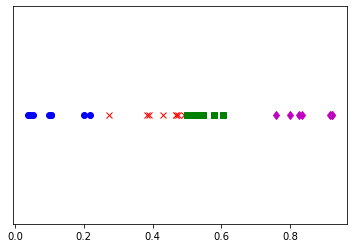

In [35]:
X, y = gen_data(n_samples=30, n_classes=4, overlap=0, random_state=1)
plot_data(X, y)

1. Compare a acurácia e as regiões de decisão para os dois tipos de classificação.
1. (OPCIONAL) Para tentar investigar a razão das diferenças, trace a curva de predição da regressão para cada classe ($\tilde{y}_k$), para cada método.
 1. Para o método one-vs-rest, parta da função `.decision_function()`
 1. Para o método softmax, utilize a função `.predict_proba()`
1. (OPCIONAL) A partir destes resultados, como você explicaria as diferenças entre os métodos? Em que tipo de situação você espera que as diferenças fiquem mais pronunciadas?